<a href="https://colab.research.google.com/github/sergienko4/deep-learing/blob/main/ex9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Ex.9 - Generative Adversarial Networks (GAN)

Submitted by: [... **namd and ID** ...]


In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

print(tf.__version__)

2.7.0


---
### Loading the dataset

This dataset contains ~20K anime-face images (each image is 64x64 pixels):

In [2]:
import gdown
from zipfile import ZipFile

url = "https://drive.google.com/uc?id=1ouH9kAGuZqTqknLvzDLiKRfCF0aqCROD"
gdown.download(url, 'data.zip', quiet=False)  # ~ 480MB

print('unzipping...')
with ZipFile("data.zip", "r") as zipobj:
    zipobj.extractall()  # unzip the file

print('done.')


Downloading...
From: https://drive.google.com/uc?id=1ouH9kAGuZqTqknLvzDLiKRfCF0aqCROD
To: /content/data.zip
100%|██████████| 240M/240M [00:02<00:00, 101MB/s] 


unzipping...
done.


Found 21551 images belonging to 1 classes.
dataset.shape = (21551, 64, 64, 3)


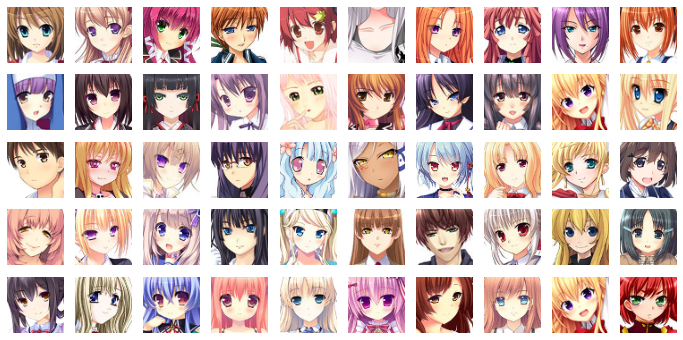

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dataGen = ImageDataGenerator(rescale=1./255)

dataset = dataGen.flow_from_directory('anime_data', target_size=(64,64), batch_size=25000, class_mode='sparse').next()[0]
print('dataset.shape =',dataset.shape)

# plot some samples:
plt.figure(figsize=(12,6))
for i in range(50):
		plt.subplot(5, 10, 1 + i)
		plt.axis('off')
		plt.imshow(dataset[i])

***

### 1. Training a GAN model 

- Use our model developed in the class presentation, and adjust its architecture to match the new dataset images shape: `(64,64,3)`.

- Use a latent dimension of 20-D as the noise input for the generator model.

- Generate 12 noise vectors (each one is of 20-D), and use these vectors to generate 12 images from the (un-trained) generator. Display the images in a single row of sublplots.



In [4]:
G_model = Sequential(name='generator')
G_model.add(Dense(256*8*8, input_dim=20))
G_model.add(LeakyReLU(alpha=0.2))
G_model.add(Reshape((8, 8, 256)))
# upsample to 16x16
G_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))

# upsample to 32x32
G_model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))

G_model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))

G_model.add(Conv2D(3, (8,8), activation='sigmoid', padding='same'))

G_model.build()
G_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             344064    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       131136    
 ranspose)                                               

In [5]:
D_model = Sequential(name='decoder')
D_model.add(Input(shape=(64,64,3)))
D_model.add(Conv2D(32, (4,4), strides=2, padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
D_model.add(Conv2D(64, (4,4), strides=2, padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
D_model.add(Conv2D(128, (4,4), strides=2, padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
D_model.add(Conv2D(256, (4,4), strides=2, padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
D_model.add(Flatten())
D_model.add(Dense(1, activation='sigmoid'))
D_model.build()
D_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        1568      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)         5245

In [6]:
adam = Adam(lr=0.0002, beta_1=0.5)
# compile D_model
D_model.compile(loss='binary_crossentropy', optimizer=adam)
# GAN model
D_model.trainable = False
GAN_model = Sequential()
GAN_model.add(G_model)
GAN_model.add(D_model)
# compile GAN_model
GAN_model.compile(loss='binary_crossentropy', optimizer=adam)
GAN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 64, 64, 3)         1038563   
                                                                 
 decoder (Sequential)        (None, 1)                 694241    
                                                                 
Total params: 1,732,804
Trainable params: 1,038,563
Non-trainable params: 694,241
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


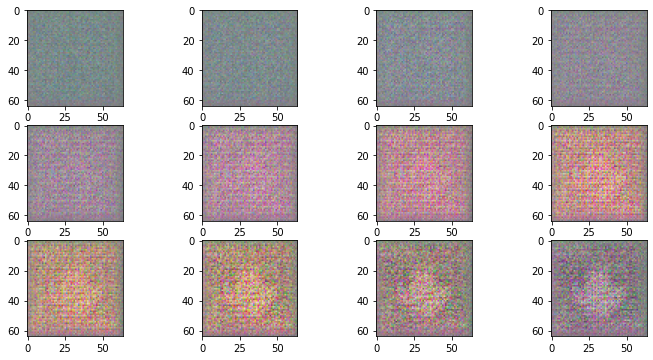

In [7]:
batch_size = 128
plt.figure(figsize=(12,6))
noise_vectors_size = 12
noise_size = (1, 20)
for i in range(noise_vectors_size):
  ix = np.random.randint(0,dataset.shape[0], batch_size)
  x_real = dataset[ix]
  y_real = np.ones((batch_size,1))

  #gen fake
  noise_input =np.random.randint(batch_size, size=noise_size)
  x_fake = G_model.predict(noise_input)
  y_fake = np.zeros((1,1))
  plt.subplot(3, 4, 1 + i)
  plt.imshow(x_fake[0])
  d_loss_real = D_model.train_on_batch(x_real,y_real)
  d_loss_fake = D_model.train_on_batch(x_fake,y_fake)


  x_gan = np.random.randint(batch_size, size=noise_size)
  y_gan = np.ones((1,1))

  g_loss = GAN_model.train_on_batch(x_gan, y_gan)


- Train the GAN model for 50-100 epochs (it take ~1min/epoch).

- After each and every epoch, feed the **same** 12 noise vectors to the generator, and plot a generated images. This will help you follow the training progress. 


In [16]:
adam = Adam(lr=0.0002, beta_1=0.5)
# compile D_model
D_model.compile(loss='binary_crossentropy', optimizer=adam)
# GAN model
D_model.trainable = False
GAN_model = Sequential()
GAN_model.add(G_model)
GAN_model.add(D_model)
# compile GAN_model
GAN_model.compile(loss='binary_crossentropy', optimizer=adam)
GAN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 64, 64, 3)         1038563   
                                                                 
 decoder (Sequential)        (None, 1)                 694241    
                                                                 
Total params: 1,732,804
Trainable params: 1,038,563
Non-trainable params: 694,241
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


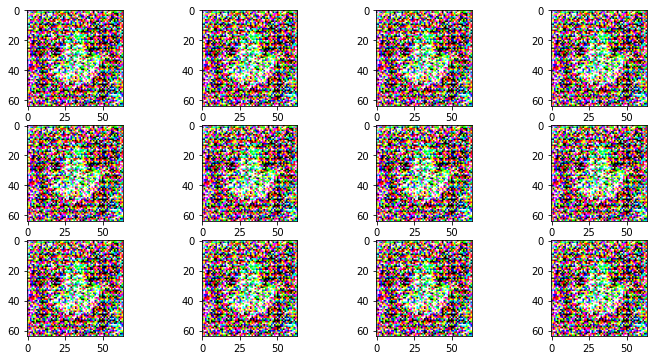

In [17]:
plt.figure(figsize=(12,6))
noise_inputs=[]
noise_vectors_size = 12

for i in range(noise_vectors_size):
  noise_input =np.random.randint(batch_size, size=noise_size)
  noise_inputs.append(noise_input)
for epochs in range(50):
  for i in range(noise_vectors_size):
    ix = np.random.randint(0,dataset.shape[0], batch_size)
    x_real = dataset[ix]
    y_real = np.ones((batch_size,1))

    #gen fake
    # noise_input =np.random.randint(batch_size, size=noise_size)
    x_fake = G_model.predict(noise_inputs[i])
    y_fake = np.zeros((1,1))
    plt.subplot(3, 4, 1 + i)
    plt.imshow(x_fake[0])
    d_loss_real = D_model.train_on_batch(x_real,y_real)
    d_loss_real = D_model.train_on_batch(x_fake,y_fake)


    x_gan = np.random.randint(batch_size, size=noise_size)
    y_gan = np.ones((1,1))

    g_loss = GAN_model.train_on_batch(x_gan, y_gan)

***

### 2. Exploring the latent (input) space

- Generate and display 64 **new** images from the generator (use 8x8 subplots).

- Pick a single "good" image out of these images, and denote the seed-vector that generated it by `z`.

- Next, generate 25 new seed vectors, based on this specific `z`, in the following way:

 - We will add a small-variance noise vector `dz` (a.k.a pertubation, also of 20-D) to `z`, and feed the new vector (`z + dz`) to the generator, to generate a new image. 
  - Use a Normal distribution with $\sigma=0.5$ for the pertubation `dz` (you can experiment with different values for $\sigma$).

- Repeat this process to generate a total of 25 new images (each generated from the same seed `z` but with a different pertubation `dz`).

- Display the results (use 5x5 subplots)






In [10]:
    ###########################
    ###  your code here...  ###
    ###########################

***
### 3. Morphing between two images


- Pick 2 out of the 64 examples you've generated in Q2. Denote the seed-vectors that generated these images by `z1` and `z2`.

- We will try to "morph" between these two images, by "walking" in the latent space from `z1` to `z2`.

 - Generate a set of 10 seed-vectors, using a linear interpolation (by varying $\alpha$ from 1 to 0):

$$ \vec{z}_{interp} \ \ =\ \  \alpha \cdot \vec{z_1} \ \ +\ \  (1-\alpha) \cdot \vec{z_2}$$

- Feed the interpolated seed vectors to the generator and display the sequence of images.



In [11]:
###########################
###  your code here...  ###
###########################

- Extend the last process to morph between 3 different images `I1`, `I2`, `I3`:
 - Generate a morphing sequence from `I1` to `I2`, from `I2` to `I3`, and from `I3` back to `I1`.

In [12]:
###########################
###  your code here...  ###
###########################

- Finally, if you wish, you can generate an animated GIF of your generated sequence:

In [13]:
anim_file = 'animation.gif'

import imageio

with imageio.get_writer(anim_file, mode='I') as writer:
    # loop over the images you want to add to the animated GIF file
    # use: writer.append_data(your_image)
    # where your_image should be np.uint8 format, with values from 0-255.
  

SyntaxError: ignored

***
## Good Luck!